# Data Wrangling & EDA

## 1 Table of Contents

- [1 Table of Contents](#1-Table-of-Contents)
- [2 Introduction](#2-Introduction)
- [3 Setup](#3-Setup)
- [4 Data Verification](#4-Data-Verification)
- [5 Distributions](#5-Distributions)
  - [5.1 Labels](#5.1-Labels)
  - [5.2 Words](#5.2-Words)
- [6 Cleaning and Preprocessing the Text](#6-Cleaning-and-Preprocessing-the-Text)
  - [6.1 Common Words](#6.1-Common-Words)

TODO

## 2 Introduction

TODO

## 3 Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time
from collections import Counter

In [2]:
train_df = pd.read_csv("../data/raw/train.csv")
print("Train shape: ", train_df.shape)
test_df = pd.read_csv("../data/raw/test.csv")
print("Test shape: ", test_df.shape)

Train shape:  (20972, 9)
Test shape:  (8989, 3)


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [4]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


In [6]:
test_df.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


## 4 Data Verification

After loading the data, we will check if the data looks okay. There should be no missing values, and the dataframes should be populated by reasonable values.

In [7]:
train_df['ID'].is_unique & train_df['TITLE'].is_unique & train_df['ABSTRACT'].is_unique

True

In [8]:
train_df.describe()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
count,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,10486.500000,0.409784,0.286716,0.267881,0.248236,0.027990,0.011873
std,6054.239259,0.491806,0.452238,0.442866,0.432000,0.164947,0.108317
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5243.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10486.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15729.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,20972.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
for c in train_df.columns[3:]:
    print(train_df[c].value_counts())

0    12378
1     8594
Name: Computer Science, dtype: int64
0    14959
1     6013
Name: Physics, dtype: int64
0    15354
1     5618
Name: Mathematics, dtype: int64
0    15766
1     5206
Name: Statistics, dtype: int64
0    20385
1      587
Name: Quantitative Biology, dtype: int64
0    20723
1      249
Name: Quantitative Finance, dtype: int64


The numeric columns make sense, and most importantly, the topic columns contain only 0 and 1.

We saw earlier that the `shape` attribute of the `test_df` was different from the `train_df` in that it had six fewer columns, so "test.csv" likely does not have labels. The information provided from the `test_df` can still be used, so we will give its data a cursory check as well.

In [10]:
test_df['ID'].is_unique & test_df['TITLE'].is_unique & test_df['ABSTRACT'].is_unique

True

## 5 Distributions

### 5.1 Labels

Let's check the label distributions.

In [11]:
# The `labels` list will hold the names of the topics
labels = train_df.columns[3:]

In [12]:
def count_labels(labels, df, print_counts=True):
    """
    Counts the number of articles marked with a label.
    
    labels : A list of column names.
    df : The DataFrame of articles with labels to count.
    print_counts : If set to true, it will print the labels and their occurrences.
    """
    label_count = []
    for label in labels:
        label_sum = df[label].sum()
        label_count.append(label_sum)
        if (print_counts):
            print("{} articles tagged with {}".format(label_sum, label))
    return label_count

def plot_topic_labels(labels, label_count):
    """
    Plots a bar chart for the label counts.
    
    labels : A list of the names of the labels
    label_count : A list of occurrences corresponding to the labels
    """
    _ = plt.figure(figsize=(15,5))
    _ = plt.title("Number of articles per topic")
    _ = plt.bar(labels, label_count)

(Admittedly, defining something like `count_labels()` could be forgone.)

8594 articles tagged with Computer Science
6013 articles tagged with Physics
5618 articles tagged with Mathematics
5206 articles tagged with Statistics
587 articles tagged with Quantitative Biology
249 articles tagged with Quantitative Finance


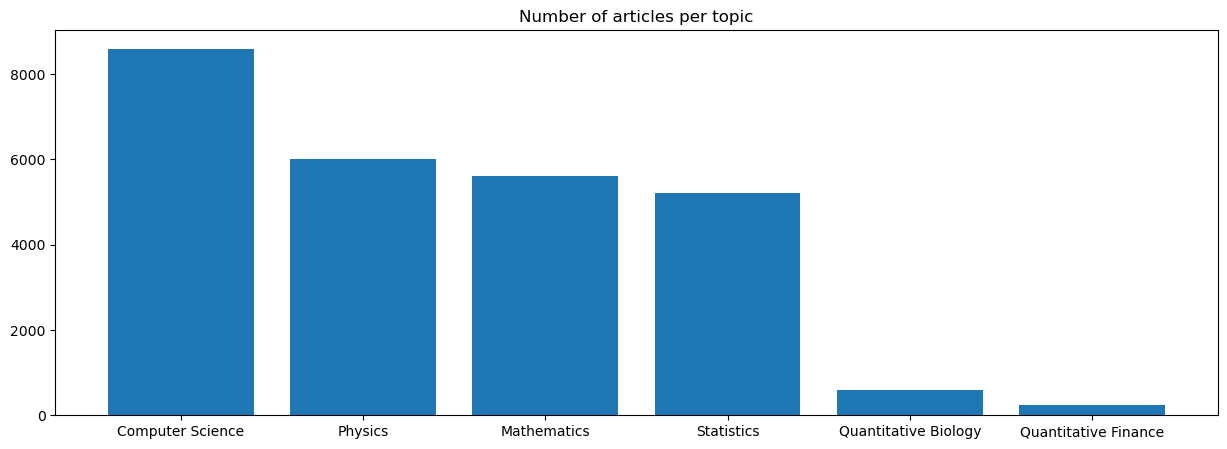

In [13]:
labels_per_topic = count_labels(labels, train_df)
plot_topic_labels(labels, labels_per_topic)

The classes are imbalanced, with 'Quantitative Biology' and 'Quantitative Finance' having relatively few articles tagged with those topics. Meanwhile, a lot of articles were marked with 'Computer Science'.

The articles could be labeled with more than one topic, so we will also check how these multi-topic articles are distributed.

In [14]:
print("Number of total tags: {}".format(np.sum(labels_per_topic)))

Number of total tags: 26267


There are 5,295 more labels than there are articles, so about 25% of the labels were given to articles that already have at least one label.

In [15]:
num_nlabels = train_df.iloc[:,3:].aggregate(np.sum, axis=1).value_counts()
print("Number of articles with n labels:")
print(num_nlabels)

Number of articles with n labels:
1    15928
2     4793
3      251
dtype: int64


A little over 1% of articles are marked with three topics, about 23% are marked with two topics, and the remaining 76% have only one topic.

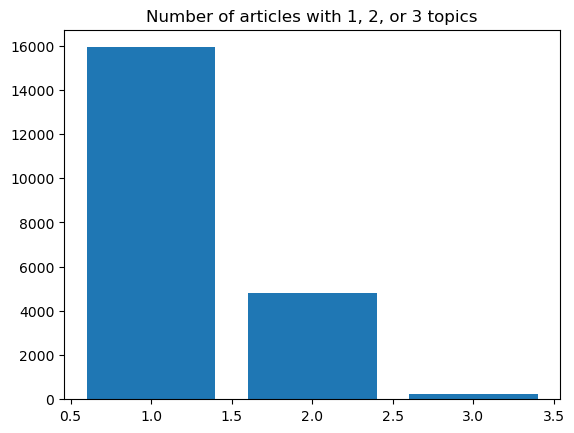

In [16]:
_ = plt.title("Number of articles with 1, 2, or 3 topics")
_ = plt.bar(num_nlabels.index, num_nlabels.values)

### 5.2 Words

The text data is not cleaned yet, but we can approximate the word counts.

In [17]:
train_df['title_abstract'] = train_df['TITLE'] + train_df['ABSTRACT']
train_df.head(3)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,title_abstract
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...


In [18]:
test_df['title_abstract'] = test_df['TITLE'] + test_df['ABSTRACT']
test_df.head(3)

,ID,TITLE,ABSTRACT,title_abstract
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,Closed-form Marginal Likelihood in Gamma-Poiss...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,Laboratory mid-IR spectra of equilibrated and ...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,Case For Static AMSDU Aggregation in WLANs Fr...


In [19]:
import re

In [20]:
train_df['wps'] = train_df.apply(lambda x: len(re.findall(r'\w+', x['title_abstract'])), axis=1)
test_df['wps'] = test_df.apply(lambda x: len(re.findall(r'\w+', x['title_abstract'])), axis=1)

In [21]:
train_df.head(3)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,title_abstract,wps
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...,287
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...,84
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,108


In [22]:
test_df.head(3)

,ID,TITLE,ABSTRACT,title_abstract,wps
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,Closed-form Marginal Likelihood in Gamma-Poiss...,110
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,Laboratory mid-IR spectra of equilibrated and ...,155
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,Case For Static AMSDU Aggregation in WLANs Fr...,134


There are around 160 or so words per sample, with the samples being the combination of the title and the abstract. As expected, the samples themselves are fairly small, but we may assume that a well-written title and abstract should summarize the key points of a paper well.

In [23]:
train_df['wps'].describe()

count    20972.000000
mean       165.534284
std         64.414866
min          5.000000
25%        119.000000
50%        161.000000
75%        208.000000
max        467.000000
Name: wps, dtype: float64

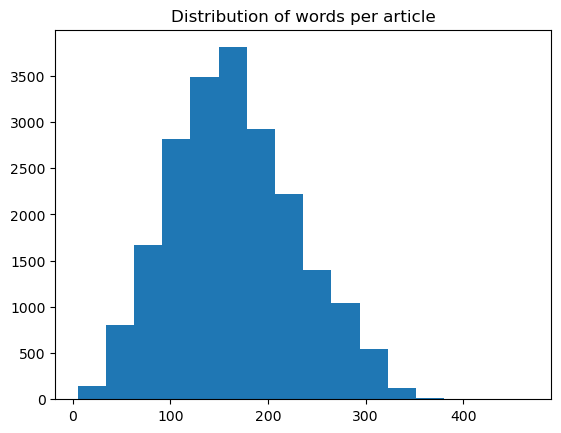

In [24]:
_ = plt.title("Distribution of words per article")
_ = plt.hist(train_df['wps'], bins=int(np.ceil(np.log2(len(train_df['wps']))) + 1))

170.0 median words in Computer Science articles
173.0 median words in Physics articles
121.0 median words in Mathematics articles
166.0 median words in Statistics articles
193.0 median words in Quantitative Biology articles
147.0 median words in Quantitative Finance articles


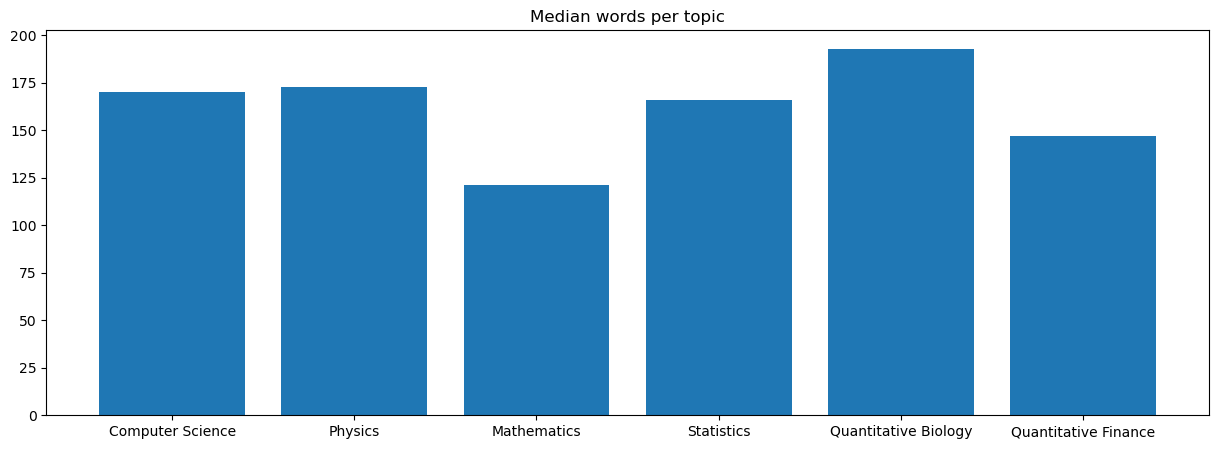

In [25]:
wps_med = []
for label in labels:
    lmed = train_df[train_df[label] == 1]['wps'].median()
    print("{} median words in {} articles".format(lmed, label))
    wps_med.append(lmed)

_ = plt.figure(figsize=(15,5))
_ = plt.title("Median words per topic")
_ = plt.bar(labels, wps_med)

## 6 Cleaning and Preprocessing the Text

The method, [`gensim.utils.simple_preprocess`](https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess), can be used to convert a document into a list of lowercase tokens. We will remove stopwords, for which we will use [`nltk.corpus`](https://www.nltk.org/api/nltk.corpus.html#module-nltk.corpus)'s `stopwords`, and we will lemmatize the tokens to group inflected words with [`nltk.stem.WordNetLemmatizer()`](https://www.nltk.org/_modules/nltk/stem/wordnet.html).

In [27]:
wordnet_lemmatizer = WordNetLemmatizer()

def preprocess(doc):
    """
    Converts a single document into a list of tokens.
    
    doc : A document of text (strings)
    """
    # Convert to a list of lowercase tokens
    tokens = simple_preprocess(doc, deacc=True)
    # Remove stopwords
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    # Lemmatize tokens
    lemma_tokens = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
    return lemma_tokens

In [28]:
## This can take 10-15 min, so commented out
#time_start = time.time()
#train_df['text'] = train_df.apply(lambda x: preprocess(x['title_abstract']), axis=1)
#time_end = time.time()
#time_elapsed = time_end - time_start
#print("Time elapsed for text preprocessing on Training Set: {} sec".format(time_elapsed))

In [29]:
## This can take ~5 min, so commented out
#time_start = time.time()
#test_df['text'] = test_df.apply(lambda x: preprocess(x['title_abstract']), axis=1)
#time_end = time.time()
#time_elapsed = time_end - time_start
#print("Time elapsed for text preprocessing on Test Set: {} sec".format(time_elapsed))

In [30]:
#train_df.to_pickle("../data/interim/1-0_train_clean.pkl")
#test_df.to_pickle("../data/interim/1-0_test_clean.pkl")

In [31]:
train_df_clean = pd.read_pickle("../data/interim/1-0_train_clean.pkl")
test_df_clean = pd.read_pickle("../data/interim/1-0_test_clean.pkl")

In [32]:
train_df_clean.sample(1)['text']

4465    [preparation, measurement, quantum, memory, mo...
Name: text, dtype: object

In [33]:
#train_df_clean['text'][0]

### 6.1 Common Words

Now that the words have been normalized and tokenized, we can look at the word counts.

In [34]:
def get_top_n(text_series, n=10):
    """
    Counts the top n most common tokens and returns them as a dictionary.
    
    text_series : A series of tokens to count.
    n : The number of most common tokens to return.
    """
    token_counter = Counter()
    for x in text_series:
        token_counter.update(x)
    top_n_tokens_dict = dict(token_counter.most_common(n))
    
    return top_n_tokens_dict

{'model': 18006, 'data': 12021, 'method': 11825, 'network': 11474, 'system': 10207, 'result': 9824, 'problem': 9576, 'based': 9493, 'time': 9271, 'show': 8846}


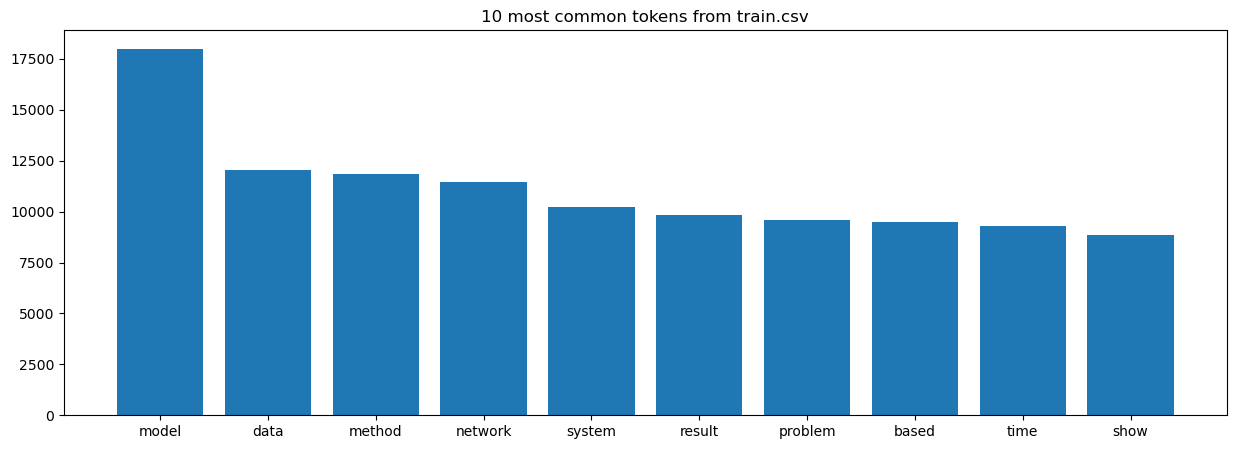

In [35]:
train_top10 = get_top_n(train_df_clean['text'], n=10)

print(train_top10)

_ = plt.figure(figsize=(15,5))
_ = plt.title("10 most common tokens from train.csv")
_ = plt.bar(train_top10.keys(), train_top10.values())

{'model': 7793, 'data': 5051, 'network': 4975, 'method': 4800, 'system': 4410, 'result': 4180, 'based': 3998, 'problem': 3957, 'time': 3894, 'using': 3811}


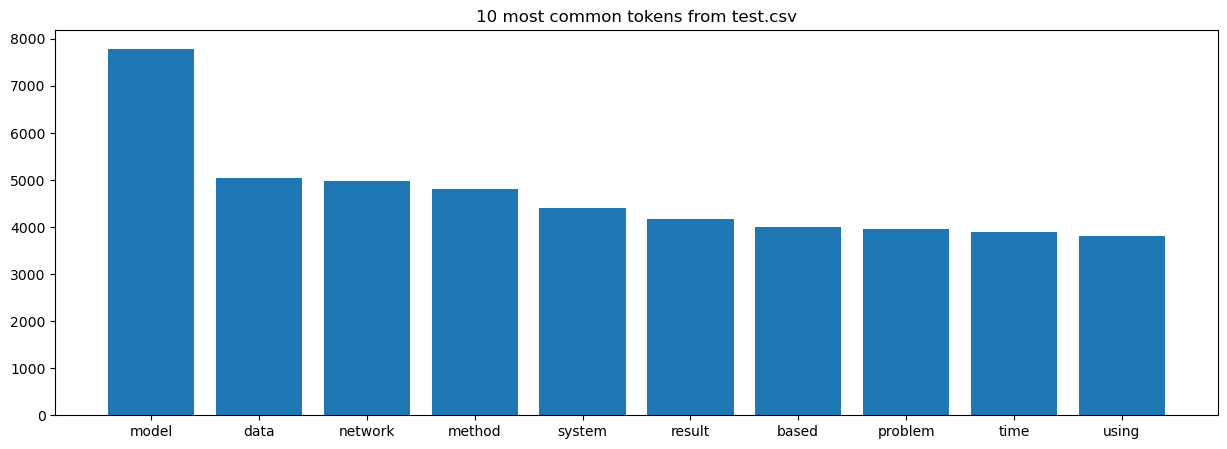

In [36]:
test_top10 = get_top_n(test_df_clean['text'], n=10)

print(test_top10)

_ = plt.figure(figsize=(15,5))
_ = plt.title("10 most common tokens from test.csv")
_ = plt.bar(test_top10.keys(), test_top10.values())

Between the "train.csv" and "test.csv", the top ten most commmonly used words were similar. Next we will check the top five words per topic.

In [37]:
label_top5 = []
for label in labels:
    top5 = get_top_n(train_df_clean[train_df[label] == 1]['text'], n=5)
    label_top5.append(top5)
    print("{}: {}".format(label, top5))

Computer Science: {'model': 8485, 'network': 8420, 'data': 6830, 'method': 6338, 'algorithm': 6219}
Physics: {'model': 4512, 'system': 3514, 'field': 3054, 'time': 2866, 'two': 2743}
Mathematics: {'problem': 2935, 'result': 2762, 'function': 2638, 'model': 2466, 'space': 2221}
Statistics: {'model': 7483, 'data': 5888, 'learning': 5113, 'method': 5107, 'network': 4771}
Quantitative Biology: {'model': 811, 'network': 761, 'data': 464, 'method': 392, 'cell': 364}
Quantitative Finance: {'model': 459, 'market': 285, 'price': 218, 'time': 187, 'risk': 158}


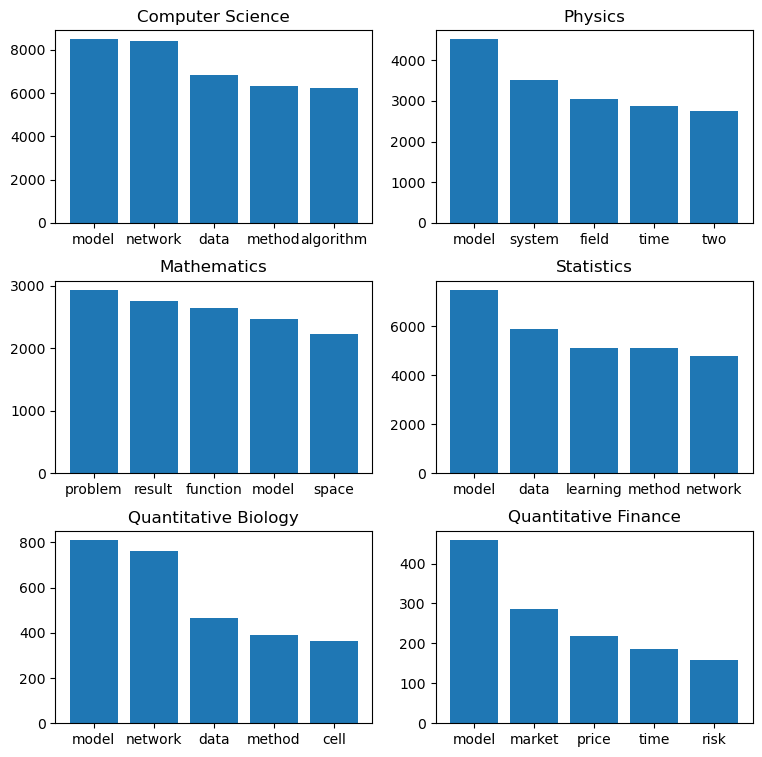

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(9,9), gridspec_kw={'hspace':0.3})

i = 0
for row in range(0,3):
    for col in range(0,2):
        _ = axs[row, col].set_title(labels[i])
        _ = axs[row, col].bar(label_top5[i].keys(), label_top5[i].values())
        i += 1

These word counts are from plain bag-of-words, without too much thought about which words are retained. A lot of these words are clearly generic "science article" words, so showing the most common words by topic is not so unique to or descriptive of a topic. These generic terms can be likened to stopwords specific to this problem space. However, there is a little bit of expression present even in this sort of basic counter: in each topic, there are 2-4 unique words.

## Conclusion
TODO: Formatting

TODO

### Save Files?

TODO